## CalMS21 multiple trials fit using rSLDS

In [1]:
from bbvi_infer_2lB import * 
from calms import *
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in data observations

In [2]:
input_name = '/data/calms_task1/calms21_task1_train.json'
with open(input_name, 'r') as fp:
    input_data = json.load(fp)
data = convert_to_array(input_data)

In [3]:
## Observations
scaler, trials = fit_scaler(data, np.arange(1, 71))
trials = [trial.cpu().numpy() for trial in trials]

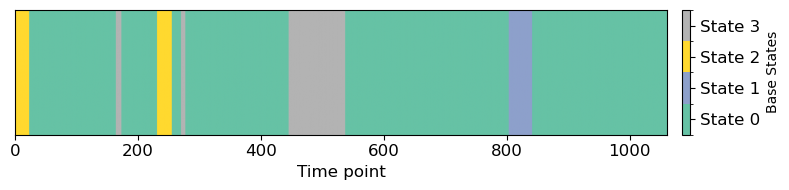

In [ ]:
## States 
states = data['annotator-id_0']['task1/train/mouse034_task1_annotator1']['annotations']
plot_soft_states(np.eye(4)[states], separate_cbar=True)

In [7]:
K=5 ## state
D=3 ## latent dimension

## rSLDS

In [7]:
import ssm
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
rslds = ssm.SLDS(N=28, K=K, D=D,
             transitions=sro_trans,
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
rslds.initialize(trials)
q_elbos_lem, q_lem = rslds.fit(trials, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 447928.4: 100%|██████████| 100/100 [1:31:27<00:00, 54.88s/it]


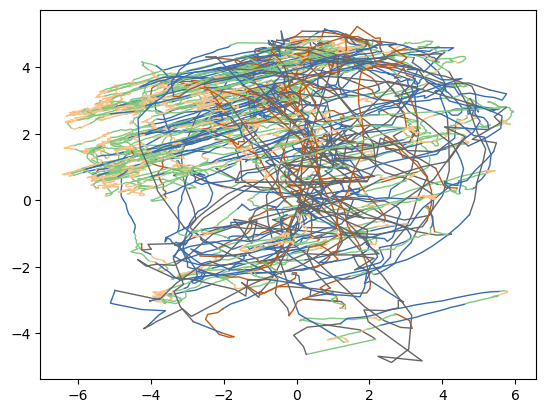

In [ ]:
q_lem_x = q_lem.mean_continuous_states[34]
q_lem_z = rslds.most_likely_states(q_lem_x, trials[1])
plot_trajectory(q_lem_z, q_lem_x)

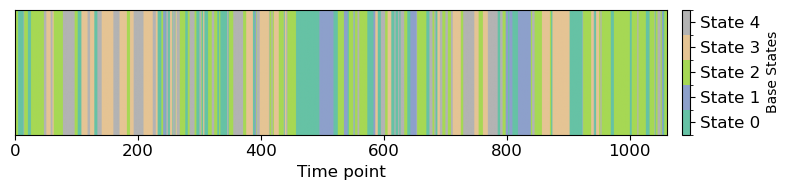

In [ ]:
plot_soft_states(np.eye(5)[rslds.most_likely_states(q_lem.mean_continuous_states[33], trials[33])],separate_cbar=True)

### Training accuracy

In [8]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[np.arange(T - 1), z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

In [9]:
def train_metrics(ys, pred_ys0, y_preds=None, k_max=0):
    if torch.is_tensor(ys): ys = ys.detach().cpu().numpy()
    if torch.is_tensor(pred_ys0): pred_ys0 = pred_ys0.detach().cpu().numpy()
    if y_preds is not None and torch.is_tensor(y_preds): 
        y_preds = y_preds.detach().cpu().numpy()
    r2_scores = []
    for k in range(k_max + 1):
        if k == 0:
            r2 = compute_r2(pred_ys0, ys)
        else:
            r2 = compute_r2(y_preds[k:, k - 1], ys[k:])
        r2_scores.append(r2)
    return r2_scores
def compute_r2(ys_pred, ys_test):
    ss_total = np.sum((ys_test - ys_test.mean(axis=0, keepdims=True))**2, axis=0)
    ss_residual = np.sum((ys_test - ys_pred)**2, axis=0)
    r2_per_unit = 1 - (ss_residual / (ss_total + 1e-8))
    return np.mean(r2_per_unit)

In [10]:
k_max = 0
all_r2_scores = []
for tr in range(len(trials)):   # trial: [T,N] tensor
    q_lem_x = q_lem.mean_continuous_states[tr]
    # Smoothed prediction
    pred_ys0 = rslds.smooth(q_lem_x, trials[tr])
    r2_per_trial = train_metrics(trials[tr], pred_ys0, None, k_max=k_max)
    all_r2_scores.append(r2_per_trial)
print(f"Collected train R² for {len(all_r2_scores)} trials")

Collected train R² for 70 trials


In [11]:
all_r2_scores

[[0.6849526736804591],
 [0.6765635012982342],
 [0.6980653709089039],
 [0.6670681040859693],
 [0.6492319526437289],
 [0.7137172653984712],
 [0.7195670834131567],
 [0.6691818745094105],
 [0.6746688359569184],
 [0.687541096221257],
 [0.6665405686475416],
 [0.678086848827471],
 [0.5884435210567951],
 [0.5510083651059913],
 [0.6098951018356148],
 [0.6462448237904911],
 [0.569588064113273],
 [0.6661770955310907],
 [0.3592235631323676],
 [0.5594060404257938],
 [0.6883434994407808],
 [0.500969556471412],
 [0.6942631783522435],
 [0.6609516786820476],
 [0.6864600709778302],
 [0.6657243525855358],
 [0.043851668274603135],
 [0.6669282406116099],
 [0.7215026105318402],
 [0.7604470659272504],
 [0.6512113075928274],
 [0.728952309450044],
 [0.612737768130554],
 [0.6884915002320401],
 [0.6778166554488209],
 [0.5045319052700982],
 [0.5371161785966179],
 [0.641798465157691],
 [0.6815251204376614],
 [-1.1412312968373526],
 [0.22954056630222425],
 [0.6501578727237207],
 [0.5185816183540298],
 [0.6322212720

In [15]:
pred_ys0 = rslds.smooth(q_lem_x, trials[1])
y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, trials[1], k=10)
print("Train accuracy:", train_metrics(trials[1], pred_ys0, y_preds, k_max=10))

Train accuracy: [0.6765635012982342, 0.6765637396208917, 0.6733675469054275, 0.6684004967142535, 0.663346961918611, 0.657941437902469, 0.6520965303267502, 0.6453671660431498, 0.6380411059316803, 0.6301398914285409, 0.6216995896998971]


### rSLDS Test performance
For test, we feed in the test dataset in CalMS21.

In [9]:
input_name = '/data/calms_task1/calms21_task1_test.json'
with open(input_name, 'r') as fp:
    input_data = json.load(fp)
data_test = convert_to_array(input_data)

In [10]:
def transform_scaler(data, scaler, mouse_ids, annotator="annotator-id_0", task="task1/test"):
    trials = []  
    # transform each trial
    for mid in mouse_ids:
        key = f"{task}/mouse{mid:03d}_{task.split('/')[0]}_annotator1"
        kp = data[annotator][key]['keypoints']
        kp_norm = normalize_by_image(kp, W, H)
        X = kp_norm.reshape(kp_norm.shape[0], -1)
        X_scaled = scaler.transform(X)
        trials.append(torch.tensor(X_scaled).to('cuda').float())
    return trials
trials_test = transform_scaler(data_test, scaler, np.arange(71, 90))
trials_test = [trial.cpu().numpy() for trial in trials_test]

In [14]:
## retrain
elbos, q_lem2 = rslds.approximate_posterior(trials_test,
                                        method="laplace_em",
                                        variational_posterior="structured_meanfield",
                                        num_iters=20)

ELBO: 203156.1: 100%|██████████| 20/20 [08:09<00:00, 24.46s/it]


In [11]:
k_max = 0
all_r2_scores1 = []
for tr in range(len(trials_test)):   # trial: [T,N] tensor
    q_lem_x2 = q_lem2.mean_continuous_states[tr]
    # Smoothed prediction
    pred_ys0 = rslds.smooth(q_lem_x2, trials_test[tr])
    r2_per_trial = train_metrics(trials_test[tr], pred_ys0, None, k_max=k_max)
    all_r2_scores1.append(r2_per_trial)
print(f"Collected test R² for {len(all_r2_scores1)} trials")

Collected test R² for 19 trials


In [12]:
all_r2_scores1

[[0.6617330601625337],
 [0.6812662516532283],
 [0.7293780918581093],
 [0.6834282998119059],
 [0.6116843645362311],
 [0.6877012343834653],
 [0.655613067705249],
 [0.6817241332561588],
 [0.7452587483607227],
 [0.6109232646787762],
 [0.6165057707962873],
 [0.6538406279761418],
 [0.6730195348869321],
 [0.7030157636835362],
 [0.7188050017467206],
 [0.6968882400599526],
 [0.7012238947381874],
 [0.7175342561350905],
 [0.7006204819793227]]

### State quality  
Caution: takes long time.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_state_quality(trials_train, trials_test, data, data_test, train_ids, test_ids,
                            n_neighbors=10):
    # TRAIN 
    Z_train_list, Y_train_list = [], []
    for tr, trial_id in zip(range(len(trials_train)), train_ids):
        # Average across M and drop batch
        Z_trial = np.eye(5)[rslds.most_likely_states(q_lem.mean_continuous_states[tr], trials[tr])]
        Y_trial = np.asarray(data['annotator-id_0'][trial_id]['annotations'])

        Z_train_list.append(Z_trial)
        Y_train_list.append(Y_trial)
    Z_train = np.vstack(Z_train_list)
    Y_train = np.concatenate(Y_train_list)
    # TEST 
    Z_test_list, Y_test_list = [], []
    per_trial_scores = []
    for tr, trial_id in zip(range(len(trials_test)), test_ids):
        Z_trial = np.eye(5)[rslds.most_likely_states(q_lem2.mean_continuous_states[tr], trials_test[tr])]
        Y_trial = np.asarray(data_test['annotator-id_0'][trial_id]['annotations'])

        Z_test_list.append(Z_trial)
        Y_test_list.append(Y_trial)
    
    Z_test = np.vstack(Z_test_list)
    Y_test = np.concatenate(Y_test_list)
    # KNN 
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean',n_jobs=-1,algorithm='kd_tree')
    knn.fit(Z_train, Y_train)
    print("Done")   
    #acc_train = knn.score(Z_train, Y_train)
    #acc_test = knn.score(Z_test, Y_test)

    # Per-test-trial accuracy
    for Z_trial, Y_trial, trial_id in zip(Z_test_list, Y_test_list, test_ids):
        acc_trial = knn.score(Z_trial, Y_trial)
        print(acc_trial)
        per_trial_scores.append(acc_trial)

    print("Train accuracy:", acc_train)
    #print("Test accuracy (all pooled):", acc_test)
    return per_trial_scores

In [14]:
train_ids = [f"task1/train/mouse{str(i).zfill(3)}_task1_annotator1" for i in range(1, 71)]
test_ids  = [f"task1/test/mouse{str(i).zfill(3)}_task1_annotator1" for i in range(71, 90)]

acc_train, per_trial_scores = evaluate_state_quality(
    trials, trials_test, data, data_test,
    train_ids, test_ids,
    n_neighbors=10)

Done
0.19651406971860563
0.23662188945166263
0.3584777615368553
0.1909694555112882
0.1276713849569803
0.13358701166920345
0.08721637488760776
0.14512401787089815
0.47777841331579246
0.4039488590386794
0.07360097323600973
0.32832044975404073
0.24011473058799426
0.07020974049057946
0.1459375
0.07786932807241499
0.6020981955518254
0.444985835694051
0.24294837679616818


NameError: name 'acc_train' is not defined

In [22]:
### mapping per train trials
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
train_ids = [f"task1/train/mouse{str(i).zfill(3)}_task1_annotator1" for i in range(1, 71)]
for tr, trial_id in zip(range(len(trials)), train_ids):
    Z_train = np.eye(5)[rslds.most_likely_states(q_lem.mean_continuous_states[tr], trials[tr])]
    Y_train = np.asarray(data['annotator-id_0'][trial_id]['annotations'])

    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc1 = knn.score(Z_train, Y_train)
    print(f"Train accuracy for {trial_id}:", acc1)

Train accuracy for task1/train/mouse001_task1_annotator1: 0.15788241902265493
Train accuracy for task1/train/mouse002_task1_annotator1: 0.6936359406503645
Train accuracy for task1/train/mouse003_task1_annotator1: 0.29473604598396613
Train accuracy for task1/train/mouse004_task1_annotator1: 0.445176913762949
Train accuracy for task1/train/mouse005_task1_annotator1: 0.7901081368551676
Train accuracy for task1/train/mouse006_task1_annotator1: 0.362495873225487
Train accuracy for task1/train/mouse007_task1_annotator1: 0.24418952618453865
Train accuracy for task1/train/mouse008_task1_annotator1: 0.6446918558779696
Train accuracy for task1/train/mouse009_task1_annotator1: 0.3940230436869899
Train accuracy for task1/train/mouse010_task1_annotator1: 0.41910916224324946
Train accuracy for task1/train/mouse011_task1_annotator1: 0.6664319248826291
Train accuracy for task1/train/mouse012_task1_annotator1: 0.2734353268428373
Train accuracy for task1/train/mouse013_task1_annotator1: 0.57048166151126